# (14.0) Описание решаемой задачи

На основании заявок, данные по которым были отражены в ордерлоге к моменту времени T необходимо восстановить очередь активных заявок ( = список лимитных заявок, которые ожидают исполнения), сформировать стакан и рассчитать его метрики:
1. лучшие цены
2. объем на уровне лучших цен
3. спред

# (14.1) Установка необходимых пакетов

In [84]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt

# (14.2) Определение функций¶

In [261]:
# перевод времени в формат datetime
def ReverseToDateTime(t):
    format = '%Y%m%d%H%M%S%f'
    time_str = dt.datetime.strptime(t,format)
    return time_str

# восстановление стакана заявок и расчет основных метрик
def GlassBuild(for_lob):
    
    #формируем очередь заявок
    
    # устанавливаем маску лимитных заявок заявках (True - лимитная заявка)
    no_mkt_orders = for_lob['PRICE']!=0
    # таблица выставленных заявок
    plc_orders = for_lob[['ORDERNO','BUYSELL','PRICE','VOLUME']][(for_lob ['ACTION']==1) & no_mkt_orders]
    # таблица отмененных заявок
    wdr_orders = for_lob[['ORDERNO','VOLUME']][(for_lob ['ACTION'] == 0) & no_mkt_orders]
    # таблица исполненных заявок
    trd_orders = for_lob [['ORDERNO','VOLUME']][(for_lob['ACTION']==2) & no_mkt_orders]
    trd_orders = trd_orders.groupby(['ORDERNO']).sum()
    trd_orders['ORDERNO'] = trd_orders.index
    trd_orders.index=range(trd_orders.shape[0])
    # собираем все типы заявок в один датафрейм - очередь заявок
    lob_almost = pd.merge(plc_orders,wdr_orders, on='ORDERNO',how='left',suffixes=('_plc','_wdr'))
    lob_almost = pd.merge(lob_almost,trd_orders, on='ORDERNO', how='left')
    lob_almost = lob_almost.rename(columns={'VOLUME':'VOLUME_trd'})
    lob_almost = lob_almost.fillna(0)
    lob_almost['TOTAL_VOL'] = lob_almost['VOLUME_plc'] - lob_almost['VOLUME_wdr'] - lob_almost['VOLUME_trd']
    # удаляем из очереди заявок заявки с нулевым или отрицательным объемом
    lob_almost = lob_almost[['ORDERNO','BUYSELL','PRICE','VOLUME_plc','VOLUME_wdr','VOLUME_trd','TOTAL_VOL']][(lob_almost['TOTAL_VOL']>0)]
    
    # строим стакан
    
    lob = lob_almost.pivot_table(index = "PRICE", columns = "BUYSELL", values = "TOTAL_VOL", aggfunc = 'sum')
    lob.sort_index(axis = 0, inplace = True, ascending = False)
    lob = lob.fillna(0)
    
    # считаем метрики ликвидности
    
    # расчет лучшей цены на покупку
    bid_price = lob[lob['B'] > 0].index[0]
    # расчет объема на уровне лучшей цены на покупку
    bid_volume = lob['B'][bid_price]
    # расчет общего объема на стороне покупки
    bid_depth = lob['B'].sum()
    # расчет объема на уровне 10 лучших цен на стороне покупки
    b_10 = lob[lob['B'] > 0].index[0:10]
    volume_b_10 = 0
    for i in b_10:
        volume_b_10 = volume_b_10 + lob['B'][i]
    # расчет лучшей цены на продажу
    ask_price = lob[lob['S'] > 0].index[-1]
    # расчет объема на уровне лучшей цены на продажу
    ask_volume = lob['S'][ask_price]
    # расчет общего объема на стороне продажи
    ask_depth = lob['S'].sum()
    # расчет объема на уровне 10 лучших цен на стороне продажи
    s_10 = lob[lob['S'] > 0].index[-10:]
    volume_s_10 = 0
    for i in s_10:
        volume_s_10 = volume_s_10 + lob['S'][i]
    
    liquidity = [bid_price, bid_volume, bid_depth, volume_b_10, ask_price, ask_volume, ask_depth, volume_s_10]
     
    return(liquidity)

# (14.3) Список всех использующихся датафреймов¶

In [4]:
# orders - ордерлог на заданную дату
# instr_orders - ордерлог на заданную дату по выбранному инструменту на момет времени t
# plc_orders - выставленные заявки
# wdr_orders - отмененные заявки
# trd_orders - исполненные заявки
# lob_almost - очередь заявок
# liquidity - метрики ликвидности на каждые 5 минут по одному инструменту за один день
# iceberg_all - список всех найденных айсбергов
# ice_instr - список айсбергов по одному инструменту за один день

# (14.4) Определение входных параметров

In [4]:
# создаем список из всех названий файлов с данными
orderlogs = ['OrderLog20190304.txt',
             'OrderLog20190305.txt',
             'OrderLog20190306.txt',
             'OrderLog20190307.txt',
             'OrderLog20190311.txt',
             'OrderLog20190312.txt',
             'OrderLog20190313.txt',
             'OrderLog20190314.txt',
             'OrderLog20190315.txt',
             'OrderLog20190318.txt',
             'OrderLog20190319.txt',
             'OrderLog20190320.txt',
             'OrderLog20190321.txt',
             'OrderLog20190322.txt',
             'OrderLog20190325.txt',
             'OrderLog20190326.txt',
             'OrderLog20190327.txt',
             'OrderLog20190328.txt',
             'OrderLog20190329.txt'
            ]

In [5]:
# создаем список из инструментов, относящихся к числу голубых фишек
tickers = ['GAZP',
           'SBER',
           'GMKN',
           'LKOH',
           'MTSS',
           'MGNT',
           'TATN',
           'NVTK',
           'YNDX',
           'ROSN',
           'FIVE',
           'VTBR',
           'SNGS',
           'CHMF',
           'ALRS'
          ]

# (14.5) Считаем метрики ликвидности внутри одного дня по одному инструменту на каждые 5 минут на основании исходных данных

In [277]:
%%time
# определяем дату, инструмент
d = orderlogs[0] #20190304
date = d[8:16]
ticker = tickers[1] #SBER
# отбираем данные для расчета
orders = pd.read_csv(d, header = 0)
instr_orders = orders[(orders.SECCODE == ticker)].reset_index() 
instr_orders ['DATE'] = date
instr_orders['together_time'] = instr_orders['DATE']+instr_orders['TIME'].apply(str)
instr_orders['TIME'] = [ReverseToDateTime(instr_orders.together_time[i]) for i in range (len(instr_orders.together_time))]
del instr_orders['together_time']

instr_orders

CPU times: user 30.2 s, sys: 1.88 s, total: 32.1 s
Wall time: 37.7 s


,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE,DATE
0,321,322,SBER,S,2019-03-04 10:00:00.000000,322,1,224.15,10,NaN,NaN,20190304
1,323,324,SBER,B,2019-03-04 10:00:00.000000,324,1,193.50,10,NaN,NaN,20190304
2,328,329,SBER,S,2019-03-04 10:00:00.000000,329,1,217.59,10,NaN,NaN,20190304
3,368,369,SBER,B,2019-03-04 10:00:00.000000,369,1,188.56,10,NaN,NaN,20190304
4,416,417,SBER,S,2019-03-04 10:00:00.000000,417,1,212.82,100,NaN,NaN,20190304
...,...,...,...,...,...,...,...,...,...,...,...,...
433344,5424213,5424214,SBER,B,2019-03-04 18:44:26.839739,2095784,0,205.31,700,NaN,NaN,20190304
433345,5424222,5424223,SBER,B,2019-03-04 18:44:32.933404,606970,0,204.50,1000,NaN,NaN,20190304
433346,5424252,5424253,SBER,S,2019-03-04 18:44:44.743345,2492156,0,206.00,10,NaN,NaN,20190304
433347,5424277,5424278,SBER,S,2019-03-04 18:44:54.361484,265974,0,210.32,43500,NaN,NaN,20190304


In [278]:
%%time 
# рассчитываем метрики ликвидности на основании восстановленного стакана на каждые пять минут
# liquidity - метрики ликвидности на каждые 5 минут по одному инструменту за один день
# определяем начальный момент времени
time = ReverseToDateTime('20190304'+'100500000000')
liquidity = []

while time <= ReverseToDateTime('20190304'+'184500000000'): # определяем конечный момент времени
    
    instrtime_orders = instr_orders[(instr_orders.TIME <= time)]
    liquidity.append([time, GlassBuild(instrtime_orders)])
    time = time + dt.timedelta(minutes=5)

liquidity = pd.DataFrame(liquidity)
liquidity['BID_PRICE'] = [liquidity[1][i][0] for i in range(len(liquidity[1]))]
liquidity['BID_VOLUME'] = [liquidity[1][i][1] for i in range(len(liquidity[1]))]
liquidity['BID_DEPTH'] = [liquidity[1][i][2] for i in range(len(liquidity[1]))]
liquidity['BID_10_DEPTH'] = [liquidity[1][i][3] for i in range(len(liquidity[1]))]
liquidity['ASK_PRICE'] = [liquidity[1][i][4] for i in range(len(liquidity[1]))]
liquidity['ASK_VOLUME'] = [liquidity[1][i][5] for i in range(len(liquidity[1]))]
liquidity['ASK_DEPTH'] = [liquidity[1][i][6] for i in range(len(liquidity[1]))]
liquidity['ASK_10_DEPTH'] = [liquidity[1][i][7] for i in range(len(liquidity[1]))]
liquidity = liquidity.rename(columns = {0:'TIME'})

del liquidity[1]

liquidity

CPU times: user 36.4 s, sys: 6.07 s, total: 42.5 s
Wall time: 27.7 s


,TIME,BID_PRICE,BID_VOLUME,BID_DEPTH,BID_10_DEPTH,ASK_PRICE,ASK_VOLUME,ASK_DEPTH,ASK_10_DEPTH
0,2019-03-04 10:05:00,206.57,18370.0,3391160.0,115620.0,206.59,1980.0,4104620.0,24960.0
1,2019-03-04 10:10:00,206.73,2390.0,3759990.0,17310.0,206.81,2500.0,4329840.0,56110.0
2,2019-03-04 10:15:00,206.75,3310.0,3810460.0,34920.0,206.80,14620.0,4634900.0,41450.0
3,2019-03-04 10:20:00,206.46,4040.0,4048960.0,150160.0,206.52,20.0,4749060.0,72720.0
4,2019-03-04 10:25:00,206.65,3010.0,4273520.0,28530.0,206.70,5170.0,5115280.0,54950.0
...,...,...,...,...,...,...,...,...,...
100,2019-03-04 18:25:00,205.75,630.0,5084660.0,38830.0,205.79,1700.0,7507330.0,88910.0
101,2019-03-04 18:30:00,205.78,2320.0,5246470.0,33170.0,205.79,820.0,7457500.0,30630.0
102,2019-03-04 18:35:00,205.77,12880.0,5611950.0,43850.0,205.78,8680.0,7493890.0,40150.0
103,2019-03-04 18:40:00,205.64,50.0,6025220.0,190240.0,205.65,1820.0,8274350.0,83330.0


# (14.6) Считаем метрики ликвидности внутри одного дня по одному инструменту на каждые 5 минут с учетом выявленных айсберг-заявок

In [52]:
# список всех заявок по инструменту за день
instr_orders

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE,DATE
0,321,322,SBER,S,2019-03-04 10:00:00.000000,322,1,224.15,10,NaN,NaN,20190304
1,323,324,SBER,B,2019-03-04 10:00:00.000000,324,1,193.50,10,NaN,NaN,20190304
2,328,329,SBER,S,2019-03-04 10:00:00.000000,329,1,217.59,10,NaN,NaN,20190304
3,368,369,SBER,B,2019-03-04 10:00:00.000000,369,1,188.56,10,NaN,NaN,20190304
4,416,417,SBER,S,2019-03-04 10:00:00.000000,417,1,212.82,100,NaN,NaN,20190304
...,...,...,...,...,...,...,...,...,...,...,...,...
433344,5424213,5424214,SBER,B,2019-03-04 18:44:26.839739,2095784,0,205.31,700,NaN,NaN,20190304
433345,5424222,5424223,SBER,B,2019-03-04 18:44:32.933404,606970,0,204.50,1000,NaN,NaN,20190304
433346,5424252,5424253,SBER,S,2019-03-04 18:44:44.743345,2492156,0,206.00,10,NaN,NaN,20190304
433347,5424277,5424278,SBER,S,2019-03-04 18:44:54.361484,265974,0,210.32,43500,NaN,NaN,20190304


In [63]:
# iceberg_all - список всех выявленных айсберг-заявок
iceberg_all = pd.read_csv('iceberg.csv', header = 0)

# добавляем расчет времени между выставлением и выявлением айсберга
iceberg_all['together_time'] = iceberg_all['DATE'].apply(str)+iceberg_all['TIME'].apply(str)
iceberg_all['together_time_identified'] = iceberg_all['DATE'].apply(str)+iceberg_all['TIME_IDENT'].apply(str)
iceberg_all['TIME'] = [ReverseToDateTime(iceberg_all.together_time[i]) for i in range (len(iceberg_all.together_time))]
iceberg_all['TIME_IDENT'] = [ReverseToDateTime(iceberg_all.together_time_identified[i]) for i in range (len(iceberg_all.together_time_identified))]
iceberg_all['DELTA'] = iceberg_all['TIME_IDENT'] - iceberg_all['TIME']
del iceberg_all['together_time']
del iceberg_all['together_time_identified']
iceberg_all

iceberg_all

,index,BUYSELL,DATE,ICEBERG,ORDERNO,PRICE,SECCODE,TIME,TIME_IDENT,VOLUME,VOLUME_INI,DELTA
0,0,B,20190304,1,199077,156.28,GAZP,2019-03-04 10:06:43.595004,2019-03-04 10:09:36.467866,-2830,2000,00:02:52.872862
1,1,B,20190304,1,359638,156.18,GAZP,2019-03-04 10:30:27.072289,2019-03-04 10:53:31.759856,-210,2000,00:23:04.687567
2,2,S,20190304,1,397852,156.58,GAZP,2019-03-04 10:36:57.193855,2019-03-04 10:38:05.393784,-3000,2000,00:01:08.199929
3,3,B,20190304,1,486370,156.18,GAZP,2019-03-04 10:53:31.809856,2019-03-04 10:53:42.904115,-1000,1790,00:00:11.094259
4,4,B,20190304,1,516105,156.03,GAZP,2019-03-04 11:00:03.906212,2019-03-04 11:00:05.256841,-1000,2000,00:00:01.350629
...,...,...,...,...,...,...,...,...,...,...,...,...
54501,436,B,20190329,1,3821455,92.47,ALRS,2019-03-29 18:32:19.963550,2019-03-29 18:32:19.963586,-360,930,00:00:00.000036
54502,437,B,20190329,1,3845898,92.58,ALRS,2019-03-29 18:35:14.255473,2019-03-29 18:35:14.256529,-1000,1000,00:00:00.001056
54503,438,B,20190329,1,3845899,92.58,ALRS,2019-03-29 18:35:14.255473,2019-03-29 18:35:14.256529,-490,1000,00:00:00.001056
54504,439,B,20190329,1,3845904,92.58,ALRS,2019-03-29 18:35:14.257134,2019-03-29 18:35:14.257134,-770,510,00:00:00


In [66]:
# отбираем список айсбергов по одному инструменту за один день
# ice_instr - список айсбергов по одному инструменту за один день
ice_instr = iceberg_all[(iceberg_all.SECCODE == ticker) & (iceberg_all.DATE == int(date))].reset_index()

del ice_instr['index']
del ice_instr['level_0']

ice_instr

,BUYSELL,DATE,ICEBERG,ORDERNO,PRICE,SECCODE,TIME,TIME_IDENT,VOLUME,VOLUME_INI,DELTA
0,B,20190304,1,47392,206.99,SBER,2019-03-04 10:00:03.463857,2019-03-04 10:00:03.463857,-920,1000,00:00:00
1,B,20190304,1,47393,206.99,SBER,2019-03-04 10:00:03.463857,2019-03-04 10:00:03.463857,-120,80,00:00:00
2,B,20190304,1,47394,206.99,SBER,2019-03-04 10:00:03.463857,2019-03-04 10:00:03.463857,-2630,880,00:00:00
3,B,20190304,1,47395,206.99,SBER,2019-03-04 10:00:03.463857,2019-03-04 10:00:03.463857,-1130,370,00:00:00
4,B,20190304,1,47396,206.99,SBER,2019-03-04 10:00:03.463857,2019-03-04 10:00:03.463857,-70,870,00:00:00
...,...,...,...,...,...,...,...,...,...,...,...
815,B,20190304,1,2454926,205.50,SBER,2019-03-04 18:13:52.680839,2019-03-04 18:13:54.820780,-820,80,00:00:02.139941
816,B,20190304,1,2455091,205.50,SBER,2019-03-04 18:13:54.878553,2019-03-04 18:13:58.463577,-11680,180,00:00:03.585024
817,B,20190304,1,2576329,205.70,SBER,2019-03-04 18:38:56.417597,2019-03-04 18:38:57.219243,-49000,30000,00:00:00.801646
818,B,20190304,1,2576487,205.70,SBER,2019-03-04 18:38:57.219797,2019-03-04 18:38:57.528890,-1000,11000,00:00:00.309093


In [279]:
%%time
# редактируем исходные данные в соответствии с выявленными айсберг-заявками: 
# по номеру айсберг-заявки ищем соответствующую ей заявку в исходных данных с action = 1 и обновляем ее объем
# на величину (VOLUME_INI - VOLUME)
    
for i in range(len(ice_instr)):
        
    orderno = ice_instr.loc[i,'ORDERNO']
    instr_orders.loc[(instr_orders['ORDERNO']==orderno) & (instr_orders['ACTION']==1),'VOLUME'] -= ice_instr.loc[i,'VOLUME']

CPU times: user 13.8 s, sys: 846 ms, total: 14.6 s
Wall time: 7.83 s


In [140]:
instr_orders[instr_orders.ORDERNO == 47392]

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE,DATE
4060,48773,48774,SBER,B,2019-03-04 10:00:03.463857,47392,1,206.99,1920,NaN,NaN,20190304
4061,48774,48775,SBER,B,2019-03-04 10:00:03.463857,47392,2,206.99,1920,2.935625e+09,206.9,20190304


In [280]:
%%time 
# считаем метрики ликвидности на основании обновленных данных и записываем их в тот же датафрейм
# рассчитываем метрики ликвидности на основании восстановленного стакана на каждые пять минут
# liquidity - метрики ликвидности на каждые 5 минут по одному инструменту за один день
# определяем начальный момент времени
liquidity1 = []
time = ReverseToDateTime('20190304'+'100500000000')

while time <= ReverseToDateTime('20190304'+'184500000000'): # определяем конечный момент времени
    
    instrtime_orders = instr_orders[(instr_orders.TIME <= time)]
    liquidity1.append([time, GlassBuild(instrtime_orders)])
    time = time + dt.timedelta(minutes=5)

liquidity1 = pd.DataFrame(liquidity1)
liquidity1['BID_PRICE_ICE'] = [liquidity1[1][i][0] for i in range(len(liquidity1[1]))]
liquidity1['BID_VOLUME_ICE'] = [liquidity1[1][i][1] for i in range(len(liquidity1[1]))]
liquidity1['BID_DEPTH_ICE'] = [liquidity1[1][i][2] for i in range(len(liquidity1[1]))]
liquidity1['BID_10_DEPTH_ICE'] = [liquidity1[1][i][3] for i in range(len(liquidity1[1]))]
liquidity1['ASK_PRICE_ICE'] = [liquidity1[1][i][4] for i in range(len(liquidity1[1]))]
liquidity1['ASK_VOLUME_ICE'] = [liquidity1[1][i][5] for i in range(len(liquidity1[1]))]
liquidity1['ASK_DEPTH_ICE'] = [liquidity1[1][i][6] for i in range(len(liquidity1[1]))]
liquidity1['ASK_10_DEPTH_ICE'] = [liquidity1[1][i][7] for i in range(len(liquidity1[1]))]

liquidity1 = liquidity1.rename(columns = {0:'TIME'})

del liquidity1[1]

liquidity1

CPU times: user 36.2 s, sys: 5.96 s, total: 42.1 s
Wall time: 27 s


,TIME,BID_PRICE_ICE,BID_VOLUME_ICE,BID_DEPTH_ICE,BID_10_DEPTH_ICE,ASK_PRICE_ICE,ASK_VOLUME_ICE,ASK_DEPTH_ICE,ASK_10_DEPTH_ICE
0,2019-03-04 10:05:00,206.57,18370.0,3391160.0,115620.0,206.59,1980.0,4104620.0,24960.0
1,2019-03-04 10:10:00,206.73,2390.0,3790730.0,17310.0,206.81,2500.0,4329840.0,56110.0
2,2019-03-04 10:15:00,206.75,3310.0,3810460.0,34920.0,206.80,14620.0,4640710.0,41450.0
3,2019-03-04 10:20:00,206.46,4040.0,4051280.0,150160.0,206.52,20.0,4754870.0,72720.0
4,2019-03-04 10:25:00,206.65,3010.0,4275840.0,28530.0,206.70,5170.0,5121090.0,54950.0
...,...,...,...,...,...,...,...,...,...
100,2019-03-04 18:25:00,205.75,630.0,5084660.0,38830.0,205.79,1700.0,7507330.0,88910.0
101,2019-03-04 18:30:00,205.78,2320.0,5246470.0,33170.0,205.79,820.0,7457500.0,30630.0
102,2019-03-04 18:35:00,205.77,12880.0,5611950.0,43850.0,205.78,8680.0,7493890.0,40150.0
103,2019-03-04 18:40:00,205.64,50.0,6025220.0,190240.0,205.65,1820.0,8274350.0,83330.0


In [281]:
# объединяем метрики ликвидности, рассчитанные на основании исходных данных с метриками ликвидности, рассчитанными на основании обновленных данных
liquidity = liquidity.merge(liquidity1, on = 'TIME', how='outer')

liquidity

,TIME,BID_PRICE,BID_VOLUME,BID_DEPTH,BID_10_DEPTH,ASK_PRICE,ASK_VOLUME,ASK_DEPTH,ASK_10_DEPTH,BID_PRICE_ICE,BID_VOLUME_ICE,BID_DEPTH_ICE,BID_10_DEPTH_ICE,ASK_PRICE_ICE,ASK_VOLUME_ICE,ASK_DEPTH_ICE,ASK_10_DEPTH_ICE
0,2019-03-04 10:05:00,206.57,18370.0,3391160.0,115620.0,206.59,1980.0,4104620.0,24960.0,206.57,18370.0,3391160.0,115620.0,206.59,1980.0,4104620.0,24960.0
1,2019-03-04 10:10:00,206.73,2390.0,3759990.0,17310.0,206.81,2500.0,4329840.0,56110.0,206.73,2390.0,3790730.0,17310.0,206.81,2500.0,4329840.0,56110.0
2,2019-03-04 10:15:00,206.75,3310.0,3810460.0,34920.0,206.80,14620.0,4634900.0,41450.0,206.75,3310.0,3810460.0,34920.0,206.80,14620.0,4640710.0,41450.0
3,2019-03-04 10:20:00,206.46,4040.0,4048960.0,150160.0,206.52,20.0,4749060.0,72720.0,206.46,4040.0,4051280.0,150160.0,206.52,20.0,4754870.0,72720.0
4,2019-03-04 10:25:00,206.65,3010.0,4273520.0,28530.0,206.70,5170.0,5115280.0,54950.0,206.65,3010.0,4275840.0,28530.0,206.70,5170.0,5121090.0,54950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2019-03-04 18:25:00,205.75,630.0,5084660.0,38830.0,205.79,1700.0,7507330.0,88910.0,205.75,630.0,5084660.0,38830.0,205.79,1700.0,7507330.0,88910.0
101,2019-03-04 18:30:00,205.78,2320.0,5246470.0,33170.0,205.79,820.0,7457500.0,30630.0,205.78,2320.0,5246470.0,33170.0,205.79,820.0,7457500.0,30630.0
102,2019-03-04 18:35:00,205.77,12880.0,5611950.0,43850.0,205.78,8680.0,7493890.0,40150.0,205.77,12880.0,5611950.0,43850.0,205.78,8680.0,7493890.0,40150.0
103,2019-03-04 18:40:00,205.64,50.0,6025220.0,190240.0,205.65,1820.0,8274350.0,83330.0,205.64,50.0,6025220.0,190240.0,205.65,1820.0,8274350.0,83330.0


In [283]:
liquidity['BID_DELTA'] = np.where(liquidity['BID_DEPTH_ICE'] > liquidity['BID_DEPTH'], liquidity['BID_DEPTH_ICE'],float('nan'))
liquidity['ASK_DELTA'] = np.where(liquidity['ASK_DEPTH_ICE'] > liquidity['ASK_DEPTH'], liquidity['ASK_DEPTH_ICE'],float('nan'))
liquidity = liquidity.reset_index()
liquidity

,level_0,index,TIME,BID_PRICE,BID_VOLUME,BID_DEPTH,BID_10_DEPTH,ASK_PRICE,ASK_VOLUME,ASK_DEPTH,...,BID_PRICE_ICE,BID_VOLUME_ICE,BID_DEPTH_ICE,BID_10_DEPTH_ICE,ASK_PRICE_ICE,ASK_VOLUME_ICE,ASK_DEPTH_ICE,ASK_10_DEPTH_ICE,BID_DELTA,ASK_DELTA
0,0,0,2019-03-04 10:05:00,206.57,18370.0,3391160.0,115620.0,206.59,1980.0,4104620.0,...,206.57,18370.0,3391160.0,115620.0,206.59,1980.0,4104620.0,24960.0,NaN,NaN
1,1,1,2019-03-04 10:10:00,206.73,2390.0,3759990.0,17310.0,206.81,2500.0,4329840.0,...,206.73,2390.0,3790730.0,17310.0,206.81,2500.0,4329840.0,56110.0,3790730.0,NaN
2,2,2,2019-03-04 10:15:00,206.75,3310.0,3810460.0,34920.0,206.80,14620.0,4634900.0,...,206.75,3310.0,3810460.0,34920.0,206.80,14620.0,4640710.0,41450.0,NaN,4640710.0
3,3,3,2019-03-04 10:20:00,206.46,4040.0,4048960.0,150160.0,206.52,20.0,4749060.0,...,206.46,4040.0,4051280.0,150160.0,206.52,20.0,4754870.0,72720.0,4051280.0,4754870.0
4,4,4,2019-03-04 10:25:00,206.65,3010.0,4273520.0,28530.0,206.70,5170.0,5115280.0,...,206.65,3010.0,4275840.0,28530.0,206.70,5170.0,5121090.0,54950.0,4275840.0,5121090.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,100,100,2019-03-04 18:25:00,205.75,630.0,5084660.0,38830.0,205.79,1700.0,7507330.0,...,205.75,630.0,5084660.0,38830.0,205.79,1700.0,7507330.0,88910.0,NaN,NaN
101,101,101,2019-03-04 18:30:00,205.78,2320.0,5246470.0,33170.0,205.79,820.0,7457500.0,...,205.78,2320.0,5246470.0,33170.0,205.79,820.0,7457500.0,30630.0,NaN,NaN
102,102,102,2019-03-04 18:35:00,205.77,12880.0,5611950.0,43850.0,205.78,8680.0,7493890.0,...,205.77,12880.0,5611950.0,43850.0,205.78,8680.0,7493890.0,40150.0,NaN,NaN
103,103,103,2019-03-04 18:40:00,205.64,50.0,6025220.0,190240.0,205.65,1820.0,8274350.0,...,205.64,50.0,6025220.0,190240.0,205.65,1820.0,8274350.0,83330.0,NaN,NaN


# (14.7) Строим график динамики метрик ликвидности до и после выявления айсберг-заявок

### 2.0 График общего объема по инструменту внутри для стороны Bid

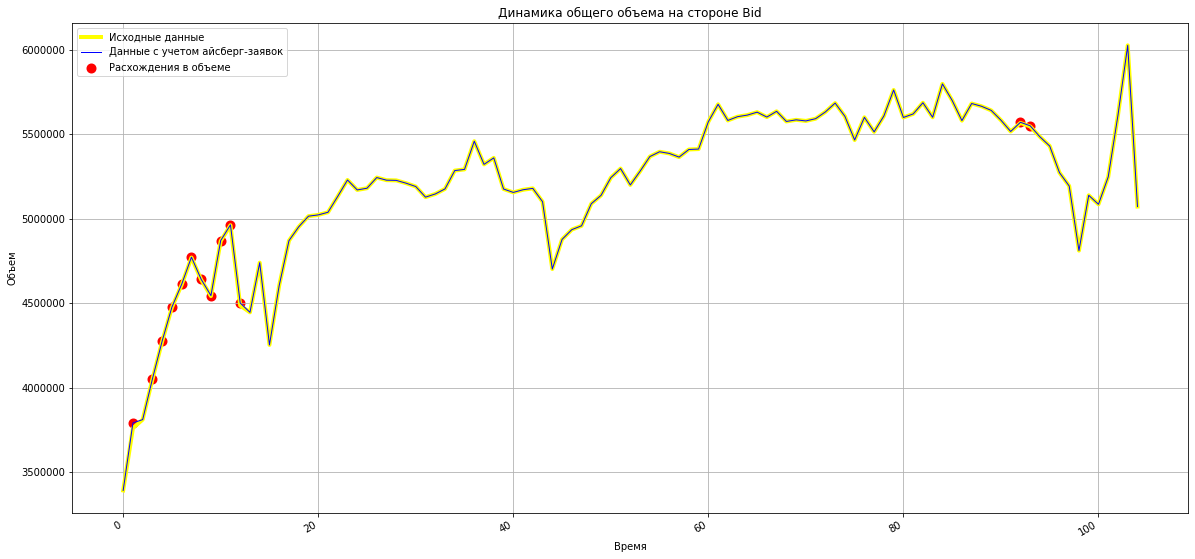

In [284]:
fig, ax = plt.subplots()
plt.grid()
plt.title('Динамика общего объема на стороне Bid')
plt.xlabel('Время')
plt.ylabel('Объем')
ax.plot(liquidity.index, liquidity.BID_DEPTH, linestyle = '-', linewidth = 4, color = 'yellow', label = 'Исходные данные')
ax.plot(liquidity.index, liquidity.BID_DEPTH_ICE, linestyle = '-', linewidth = 1, color = 'blue', label = 'Данные с учетом айсберг-заявок')
ax.scatter(liquidity.index, liquidity.BID_DELTA, linestyle = '-', linewidth = 4, color = 'red', label = 'Расхождения в объеме')
ax.legend()
fig.set_figwidth(20)
fig.set_figheight(10)
plt.gcf().autofmt_xdate()
plt.show()
fig.savefig('20 График общего объема по инструменту внутри для стороны Bid.png')

### 2.1 График общего объема по инструменту внутри для стороны Ask

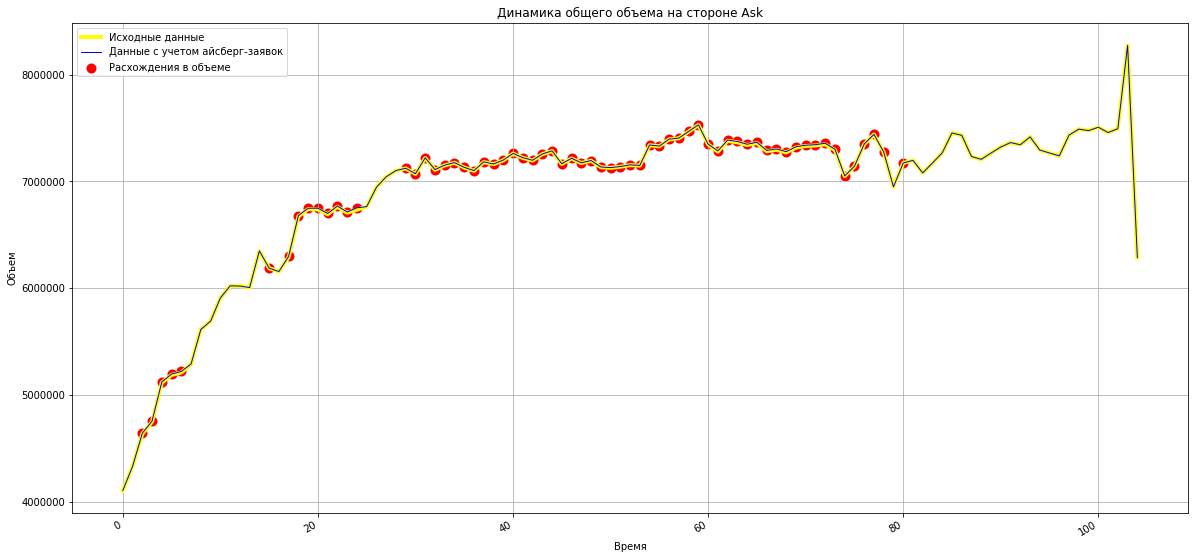

In [285]:
fig, ax = plt.subplots()
plt.grid()
plt.title('Динамика общего объема на стороне Ask')
plt.xlabel('Время')
plt.ylabel('Объем')
ax.plot(liquidity.index, liquidity.ASK_DEPTH, linestyle = '-', linewidth = 4, color = 'yellow', label = 'Исходные данные')
ax.plot(liquidity.index, liquidity.ASK_DEPTH_ICE, linestyle = '-', linewidth = 1, color = 'blue', label = 'Данные с учетом айсберг-заявок')
ax.scatter(liquidity.index, liquidity.ASK_DELTA, linestyle = '-', linewidth = 4, color = 'red', label = 'Расхождения в объеме')
ax.legend()
fig.set_figwidth(20)
fig.set_figheight(10)
plt.gcf().autofmt_xdate()
plt.show()
fig.savefig('21 График общего объема по инструменту внутри для стороны Ask.png')

# (14.12) Объединяем итоги группировки айсберг-заявок и вычисленных состояний стакана

In [52]:
%%time
liquidity2 = liquidity1.merge(ice_per_5min1, on = ['SECCODE', 'TIME', 'DATE'])

liquidity2

CPU times: user 34.5 ms, sys: 4.64 ms, total: 39.1 ms
Wall time: 50 ms


,TIME,DATE,SECCODE,BID_PRICE,BID_VOLUME,ASK_PRICE,ASK_VOLUME,SPREAD,together_time,FLAG,ICE_COUNT
0,2019-03-04 10:05:00,20190304,GAZP,156.38,610,156.40,2880,0.02,2019-03-04 10:05:00,0,0
1,2019-03-04 10:10:00,20190304,GAZP,156.26,22160,156.30,800,0.04,2019-03-04 10:10:00,0,0
2,2019-03-04 10:15:00,20190304,GAZP,156.36,10,156.40,2290,0.04,2019-03-04 10:15:00,0,0
3,2019-03-04 10:20:00,20190304,GAZP,156.10,2210,156.16,2430,0.06,2019-03-04 10:20:00,0,0
4,2019-03-04 10:25:00,20190304,GAZP,156.30,410,156.36,460,0.06,2019-03-04 10:25:00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
29920,2019-03-29 18:25:00,20190329,ALRS,92.27,10,92.28,19150,0.01,2019-03-29 18:25:00,0,0
29921,2019-03-29 18:30:00,20190329,ALRS,92.49,3020,92.51,1320,0.02,2019-03-29 18:30:00,0,0
29922,2019-03-29 18:35:00,20190329,ALRS,92.58,15410,92.59,34590,0.01,2019-03-29 18:35:00,0,0
29923,2019-03-29 18:40:00,20190329,ALRS,92.56,1240,92.59,4500,0.03,2019-03-29 18:40:00,0,0


# (14.9) Создаем цикл для расчета метрик ликвидности по всем инструментам на каждые 5 минут внутри одного дня

In [84]:
%%time
# определяем дату
date = '20190304'
# отбираем данные для расчета
orders = pd.read_csv(orderlogs[0], header = 0)
print(1)
orders ['DATE'] = d
orders['together_time'] = orders['DATE'].apply(str) + orders['TIME'].apply(str)
orders['TIME'] = [ReverseToDateTime(orders.together_time[i]) for i in range (len(orders.together_time))]
del orders['together_time']
print(2)

liquidity = []

for ticker in tickers:
    
    ticker = ticker # определяем инструмент, для которого осуществляется расчет
    instr_orders = orders[(orders.SECCODE == ticker)].reset_index() # отбираем данные по инструменту
    time = ReverseToDateTime('20190304'+'100500000000') # определяем начальный момент времени
    
    while time <= ReverseToDateTime('20190304'+'184500000000'): # определяем конечный момент времени
    
        # восстанавливаем книгу лимитированных заявок
        # отбираем данные в соответствии с правой границей времени
        instrtime_orders = instr_orders[(instr_orders.TIME <= time)]
        # устанавливаем маску лимитных заявок заявках (True - лимитная заявка)
        no_mkt_orders = instrtime_orders['PRICE']!=0
        # таблица выставленных заявок
        plc_orders = instrtime_orders[['ORDERNO','BUYSELL','PRICE','VOLUME']][(instrtime_orders['ACTION']==1) & no_mkt_orders]
        # таблица отмененных заявок
        wdr_orders = instrtime_orders [['ORDERNO','VOLUME']][(instrtime_orders['ACTION'] == 0) & no_mkt_orders]
        # таблица исполненных заявок
        trd_orders = instrtime_orders[['ORDERNO','VOLUME']][(instrtime_orders['ACTION']==2) & no_mkt_orders]
        trd_orders = trd_orders[['ORDERNO','VOLUME']].groupby(['ORDERNO']).sum()
        trd_orders['ORDERNO'] = trd_orders.index
        trd_orders.index=range(trd_orders.shape[0])
        # собираем все типы заявок в один датафрейм - очередь заявок
        lob_almost = pd.merge(plc_orders,wdr_orders, on='ORDERNO',how='left',suffixes=('_plc','_wdr'))
        lob_almost = pd.merge(lob_almost,trd_orders, on='ORDERNO', how='left')
        lob_almost = lob_almost.rename(columns={'VOLUME':'VOLUME_trd'})
        lob_almost = lob_almost.fillna(0)
        lob_almost['TOTAL_VOL'] = lob_almost['VOLUME_plc'] - lob_almost['VOLUME_wdr'] - lob_almost['VOLUME_trd']
        # удаляем из очереди заявок заявки с нулевым или отрицательным объемом
        lob_almost = lob_almost[['ORDERNO','BUYSELL','PRICE','VOLUME_plc','VOLUME_wdr','VOLUME_trd','TOTAL_VOL']][(lob_almost['TOTAL_VOL']>0)]

        # строим стакан
        lob = lob_almost[lob_almost['TOTAL_VOL']>0].pivot_table(index = "PRICE", columns = "BUYSELL", values = "TOTAL_VOL", aggfunc = 'sum')
        lob.sort_index(axis = 0, inplace = True, ascending = False)
        lob = lob.fillna(0)
        # расчет лучшей цены на покупку
        bid_price = lob[lob['B'] > 0].index[0]
        # расчет объема на уровне лучшей цены на покупку
        bid_volume = lob['B'][bid_price]
        # расчет лучшей цены на продажу
        ask_price = lob[lob['S'] > 0].index[-1]
        # расчет объема на уровне лучшей цены на продажу
        ask_volume = lob['S'][ask_price]
        # расчет спреда
        spread = ask_price - bid_price

        # записываем полученные результаты в список
        liquidity.append([time, ticker, bid_price, bid_volume, ask_price, ask_volume, spread])

        time = time + dt.timedelta(minutes=5)
        
    print(ticker, bid_price, bid_volume, ask_price, ask_volume, spread)


1
2
GAZP 154.66 250.0 154.69 4680.0 0.030000000000001137
SBER 205.63 730.0 205.7 11000.0 0.06999999999999318
GMKN 13834.0 2.0 13842.0 11.0 8.0
LKOH 5543.5 37.0 5547.5 1.0 4.0
MTSS 255.65 100.0 255.95 20.0 0.29999999999998295
MGNT 3861.0 144.0 3862.5 36.0 1.5
TATN 771.4 50.0 772.0 40.0 0.6000000000000227
NVTK 1091.0 10.0 1093.4 10.0 2.400000000000091
YNDX 2303.6 42.0 2304.0 1.0 0.40000000000009095
ROSN 399.05 30.0 399.3 1260.0 0.25
FIVE 1664.5 10.0 1669.0 75.0 4.5
VTBR 0.03596 80000.0 0.03599 1100000.0 3.0000000000002247e-05
SNGS 25.43 7300.0 25.45 1200.0 0.019999999999999574
CHMF 1042.6 30.0 1043.8 10.0 1.2000000000000455
ALRS 93.61 20.0 93.7 430.0 0.09000000000000341
CPU times: user 8min 48s, sys: 28.7 s, total: 9min 17s
Wall time: 8min 41s


In [1]:
liquidity1 = pd.DataFrame(liquidity)
liquidity1.rename(columns={0: 'TIME', 1: 'SECCODE', 2: 'BID_PRICE', 3: 'BID_VOLUME', 4: 'ASK_PRICE', 5: 'ASK_VOLUME', 6: 'SPREAD'}, inplace=True)
liquidity1

NameError: name 'pd' is not defined

# (14.10) Создаем цикл для расчета метрик ликвидности по всем инструментам на каждые 5 минут для всех дней

In [14]:
%%time
liquidity = []

for l in orderlogs:
    
    print(0)
    date = l[8:16]
    orders = pd.read_csv(l, header = 0)
    print(1)
    orders ['DATE'] = date
    orders['together_time'] = orders['DATE'].apply(str) + orders['TIME'].apply(str)
    orders['TIME'] = [ReverseToDateTime(orders.together_time[i]) for i in range (len(orders.together_time))]
    del orders['together_time']
    print(2)
    
    for ticker in tickers:
    
        ticker = ticker # определяем инструмент, для которого осуществляется расчет
        instr_orders = orders[(orders.SECCODE == ticker)].reset_index() # отбираем данные по инструменту
        time = ReverseToDateTime(date + '100500000000') # определяем начальный момент времени
    
        while time <= ReverseToDateTime(date + '184500000000'): # определяем конечный момент времени
    
            # восстанавливаем книгу лимитированных заявок
            # отбираем данные в соответствии с правой границей времени
            instrtime_orders = instr_orders[(instr_orders.TIME <= time)]
            # устанавливаем маску лимитных заявок заявках (True - лимитная заявка)
            no_mkt_orders = instrtime_orders['PRICE']!=0
            # таблица выставленных заявок
            plc_orders = instrtime_orders[['ORDERNO','BUYSELL','PRICE','VOLUME']][(instrtime_orders['ACTION']==1) & no_mkt_orders]
            # таблица отмененных заявок
            wdr_orders = instrtime_orders [['ORDERNO','VOLUME']][(instrtime_orders['ACTION'] == 0) & no_mkt_orders]
            # таблица исполненных заявок
            trd_orders = instrtime_orders[['ORDERNO','VOLUME']][(instrtime_orders['ACTION']==2) & no_mkt_orders]
            trd_orders = trd_orders[['ORDERNO','VOLUME']].groupby(['ORDERNO']).sum()
            trd_orders['ORDERNO'] = trd_orders.index
            trd_orders.index=range(trd_orders.shape[0])
            # собираем все типы заявок в один датафрейм - очередь заявок
            lob_almost = pd.merge(plc_orders,wdr_orders, on='ORDERNO',how='left',suffixes=('_plc','_wdr'))
            lob_almost = pd.merge(lob_almost,trd_orders, on='ORDERNO', how='left')
            lob_almost = lob_almost.rename(columns={'VOLUME':'VOLUME_trd'})
            lob_almost = lob_almost.fillna(0)
            lob_almost['TOTAL_VOL'] = lob_almost['VOLUME_plc'] - lob_almost['VOLUME_wdr'] - lob_almost['VOLUME_trd']
            # удаляем из очереди заявок заявки с нулевым или отрицательным объемом
            lob_almost = lob_almost[['ORDERNO','BUYSELL','PRICE','VOLUME_plc','VOLUME_wdr','VOLUME_trd','TOTAL_VOL']][(lob_almost['TOTAL_VOL']>0)]

            # строим стакан
            lob = lob_almost[lob_almost['TOTAL_VOL']>0].pivot_table(index = "PRICE", columns = "BUYSELL", values = "TOTAL_VOL", aggfunc = 'sum')
            lob.sort_index(axis = 0, inplace = True, ascending = False)
            lob = lob.fillna(0)
            # расчет лучшей цены на покупку
            bid_price = lob[lob['B'] > 0].index[0]
            # расчет объема на уровне лучшей цены на покупку
            bid_volume = lob['B'][bid_price]
            # расчет лучшей цены на продажу
            ask_price = lob[lob['S'] > 0].index[-1]
            # расчет объема на уровне лучшей цены на продажу
            ask_volume = lob['S'][ask_price]
            # расчет спреда
            spread = ask_price - bid_price

            # записываем полученные результаты в список
            liquidity.append([time, date, ticker, bid_price, bid_volume, ask_price, ask_volume, spread])

            time = time + dt.timedelta(minutes = 5)
        
        print(time, date, ticker, bid_price, bid_volume, ask_price, ask_volume, spread)

0
1
2
2019-03-04 18:50:00 20190304 GAZP 154.66 250.0 154.69 4680.0 0.030000000000001137
2019-03-04 18:50:00 20190304 SBER 205.63 730.0 205.7 11000.0 0.06999999999999318
2019-03-04 18:50:00 20190304 GMKN 13834.0 2.0 13842.0 11.0 8.0
2019-03-04 18:50:00 20190304 LKOH 5543.5 37.0 5547.5 1.0 4.0
2019-03-04 18:50:00 20190304 MTSS 255.65 100.0 255.95 20.0 0.29999999999998295
2019-03-04 18:50:00 20190304 MGNT 3861.0 144.0 3862.5 36.0 1.5
2019-03-04 18:50:00 20190304 TATN 771.4 50.0 772.0 40.0 0.6000000000000227
2019-03-04 18:50:00 20190304 NVTK 1091.0 10.0 1093.4 10.0 2.400000000000091
2019-03-04 18:50:00 20190304 YNDX 2303.6 42.0 2304.0 1.0 0.40000000000009095
2019-03-04 18:50:00 20190304 ROSN 399.05 30.0 399.3 1260.0 0.25
2019-03-04 18:50:00 20190304 FIVE 1664.5 10.0 1669.0 75.0 4.5
2019-03-04 18:50:00 20190304 VTBR 0.03596 80000.0 0.03599 1100000.0 3.0000000000002247e-05
2019-03-04 18:50:00 20190304 SNGS 25.43 7300.0 25.45 1200.0 0.019999999999999574
2019-03-04 18:50:00 20190304 CHMF 1042.

2019-03-14 18:50:00 20190314 TATN 729.3 1600.0 730.8 140.0 1.5
2019-03-14 18:50:00 20190314 NVTK 1059.4 60.0 1060.6 110.0 1.199999999999818
2019-03-14 18:50:00 20190314 YNDX 2303.0 12.0 2305.4 30.0 2.400000000000091
2019-03-14 18:50:00 20190314 ROSN 398.8 14970.0 399.0 40.0 0.19999999999998863
2019-03-14 18:50:00 20190314 FIVE 1613.5 2.0 1617.0 5.0 3.5
2019-03-14 18:50:00 20190314 VTBR 0.03611 11710000.0 0.03612 12140000.0 9.999999999996123e-06
2019-03-14 18:50:00 20190314 SNGS 24.21 600.0 24.25 100.0 0.03999999999999915
2019-03-14 18:50:00 20190314 CHMF 1005.2 20.0 1005.6 10.0 0.39999999999997726
2019-03-14 18:50:00 20190314 ALRS 95.51 1260.0 95.61 880.0 0.09999999999999432
0
1
2
2019-03-15 18:50:00 20190315 GAZP 153.3 310.0 153.39 3000.0 0.08999999999997499
2019-03-15 18:50:00 20190315 SBER 203.9 60280.0 203.99 1300.0 0.09000000000000341
2019-03-15 18:50:00 20190315 GMKN 14188.0 8.0 14198.0 5.0 10.0
2019-03-15 18:50:00 20190315 LKOH 5626.5 200.0 5633.5 100.0 7.0
2019-03-15 18:50:00 2

2019-03-25 18:50:00 20190325 FIVE 1618.0 572.0 1621.5 17.0 3.5
2019-03-25 18:50:00 20190325 VTBR 0.036375 10040000.0 0.036405 21390000.0 3.0000000000002247e-05
2019-03-25 18:50:00 20190325 SNGS 24.515 28400.0 24.54 10000.0 0.02499999999999858
2019-03-25 18:50:00 20190325 CHMF 1009.0 700.0 1009.8 130.0 0.7999999999999545
2019-03-25 18:50:00 20190325 ALRS 95.61 4650.0 95.77 20.0 0.1599999999999966
0
1
2
2019-03-26 18:50:00 20190326 GAZP 151.37 250.0 151.46 1000.0 0.09000000000000341
2019-03-26 18:50:00 20190326 SBER 217.83 190.0 217.9 1770.0 0.06999999999999318
2019-03-26 18:50:00 20190326 GMKN 14288.0 213.0 14300.0 18.0 12.0
2019-03-26 18:50:00 20190326 LKOH 5802.5 1.0 5805.0 1869.0 2.5
2019-03-26 18:50:00 20190326 MTSS 262.5 2830.0 263.45 4200.0 0.9499999999999886
2019-03-26 18:50:00 20190326 MGNT 3759.0 102.0 3765.0 1.0 6.0
2019-03-26 18:50:00 20190326 TATN 756.9 10.0 758.3 50.0 1.3999999999999773
2019-03-26 18:50:00 20190326 NVTK 1079.2 30.0 1081.4 20.0 2.2000000000000455
2019-03-26 

In [15]:
liquidity1 = pd.DataFrame(liquidity)
liquidity1.rename(columns={'0': 'TIME', '1': 'DATE', '2': 'SECCODE', '3': 'BID_PRICE', '4': 'BID_VOLUME', '5': 'ASK_PRICE', '6': 'ASK_VOLUME', '7': 'SPREAD'}, inplace=True)

liquidity1

,0,1,2,3,4,5,6,7
0,2019-03-04 10:05:00,20190304,GAZP,156.38,610.0,156.40,2880.0,0.02
1,2019-03-04 10:10:00,20190304,GAZP,156.26,22160.0,156.30,800.0,0.04
2,2019-03-04 10:15:00,20190304,GAZP,156.36,10.0,156.40,2290.0,0.04
3,2019-03-04 10:20:00,20190304,GAZP,156.10,2210.0,156.16,2430.0,0.06
4,2019-03-04 10:25:00,20190304,GAZP,156.30,410.0,156.36,460.0,0.06
...,...,...,...,...,...,...,...,...
31495,2019-03-29 18:25:00,20190329,ALRS,92.27,10.0,92.28,19150.0,0.01
31496,2019-03-29 18:30:00,20190329,ALRS,92.49,3020.0,92.51,1320.0,0.02
31497,2019-03-29 18:35:00,20190329,ALRS,92.58,15410.0,92.59,34590.0,0.01
31498,2019-03-29 18:40:00,20190329,ALRS,92.56,1240.0,92.59,4500.0,0.03


0.558782115661578